In [12]:
import platform
import netket as nk

print("Python version (requires >=3.9)", platform.python_version())
print("NetKet version (requires >=3.9.1)", nk.__version__)

Python version (requires >=3.9) 3.11.10
NetKet version (requires >=3.9.1) 3.15.2


In [13]:
# Define a 1d chain
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

In [14]:
# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


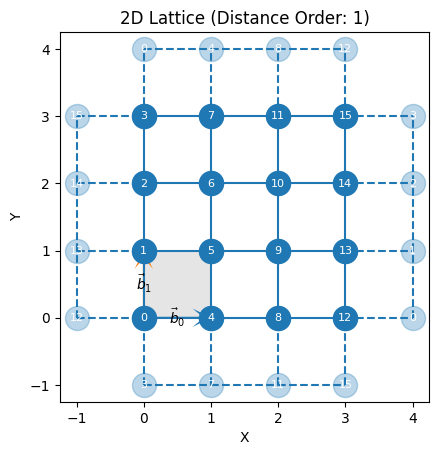

In [15]:
g.draw();

In [16]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes, inverted_ordering=True)

In [17]:
sx_1 = nk.operator.spin.sigmax(hi, 1)
sy_2 = nk.operator.spin.sigmay(hi, 2)
sz_2 = nk.operator.spin.sigmaz(hi, 2)

In [18]:
print(sx_1)

LocalOperator(dim=16, acting_on=[(1,)], constant=0.0, dtype=float64)


In [19]:
# This creates an empty operator (or zero) to which you can add others.
hamiltonian = nk.operator.LocalOperator(hi)

# now add all terms acting on single sites
h = 1.0
J = 1
for site in g.nodes(): # every node (take the list of nodes from the graph object g that we constructed before)
    # TODO
    hamiltonian = hamiltonian - h * nk.operator.spin.sigmax(hi, site) 

    # now add all terms acting on multiple sites
for (i,j) in g.edges(): # every edge (take the list of edges from the graph object)
    hamiltonian = hamiltonian + J * nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, j)

In [20]:
import numpy as np

hamiltonian_correct = nk.operator.Ising(hi, g, h=1.0, J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5

In [21]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

In [22]:
hamiltonian_jax.to_sparse()

BCSR(float64[65536, 65536], nse=1114112)

In [23]:
# use scipy.sparse.linalg.eigsh instead of numpy.linalg.eigh because
# the sparse version is much faster as it uses sparsity!
from scipy.sparse.linalg import eigsh

# k=1 to only get one eigenvalue
e_gs, psi_gs = eigsh(hamiltonian.to_sparse(), k=1)
# get ground state energy and
e_gs = e_gs[0]
# ground state
psi_gs = psi_gs.reshape(-1)

In [24]:
# todelete
from scipy.sparse.linalg import eigsh
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1)
e_gs = e_gs[0]
psi_gs = psi_gs.reshape(-1)
e_gs

np.float64(-34.010597550846235)

In [25]:
import jax

# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, N)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(lam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

In [26]:
# create an instance of the model
model = MF()

# pick a RNG key to initialise the random parameters
key = jax.random.key(0)

# initialise the weights
parameters = model.init(key, np.random.rand(hi.size))

In [27]:
parameters

{'params': {'lambda': Array([-0.01280742], dtype=float64)}}

In [28]:
dict1 = {'a':1, 'b':2}
dict2 = {'a':1, 'b':-2}

def multiply_by_10(x):
    return 10*x

print("multiply_by_10:             ", jax.tree.map(multiply_by_10,  dict1))
# this can also be done by defining the function as a lambda function, which is more compact
print("multiply_by_10, with lambda:", jax.tree.map(lambda x: 10*x,  dict1))

def add(x,y):
    return x+y
print("add dict1 and 2          :", jax.tree.map(add, dict1, dict2))


def sub(x,y):
    return x-y
print("subtract dict1 and 2        :", jax.tree.map(sub, dict1, dict2))
print("subtract dict1 and 2, lambda:", jax.tree.map(lambda x,y:x-y, dict1, dict2))

multiply_by_10:              {'a': 10, 'b': 20}
multiply_by_10, with lambda: {'a': 10, 'b': 20}
add dict1 and 2          : {'a': 2, 'b': 0}
subtract dict1 and 2        : {'a': 0, 'b': 4}
subtract dict1 and 2, lambda: {'a': 0, 'b': 4}


In [29]:
# generate 4 random inputs
inputs = hi.random_state(jax.random.key(1), (4,))

log_psi = model.apply(parameters, inputs)
# notice that logpsi has shape (4,) because we fed it 4 random configurations.
print(log_psi.shape)

(4,)


In [30]:
def to_array(model, parameters): # -> Array:
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    log_psi = model.apply(parameters, all_configurations)
    psi = jnp.exp(log_psi)
    
    return psi/ jnp.linalg.norm(psi)

In [31]:
assert to_array(model, parameters).shape == (hi.n_states, )
assert np.all(to_array(model, parameters) > 0)
np.testing.assert_allclose(np.linalg.norm(to_array(model, parameters)), 1.0)

In [32]:
%timeit to_array(model, parameters)

1.68 ms ± 29.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
# static_argnames must be used to tag any argument that is not a pytree or an array. In this case, the model.
to_array_jit = jax.jit(to_array, static_argnames="model")

# run it once to compile it, before benchmarking
to_array_jit(model, parameters)

Array([0.00411091, 0.00408467, 0.00408467, ..., 0.0037344 , 0.0037344 ,
       0.00371056], dtype=float64)

In [34]:
%timeit to_array_jit(model, parameters)

106 μs ± 327 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [42]:
# todo
def compute_energy(model, parameters, hamiltonian):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj() @ (hamiltonian @ psi_gs)

In [36]:
# if all is good, this should not error
assert compute_energy(model, parameters, hamiltonian.to_sparse()).shape == ()
assert compute_energy(model, parameters, hamiltonian.to_sparse()) < 0

In [44]:
# and like before, we can jit-compile it!
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

In [45]:
%timeit compute_energy(model, parameters, hamiltonian_sparse)
%timeit compute_energy_jit(model, parameters, hamiltonian_jax_sparse)

3.3 ms ± 29.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
62 μs ± 32.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
@partial(jax.jit, static_argnames='model')
def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    return grad_fun(model, parameters, hamiltonian_sparse)

In [47]:
energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
print(gradient)

{'params': {'lambda': Array([-0.25613552], dtype=float64)}}


In [48]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]
        J = self.param(
            "J", nn.initializers.normal(), (n_sites,n_sites), float
        )
        J_symm = J.T + J
        return jnp.einsum("...i,ij,...j", x, J_symm, x)

In [49]:
# if the code above is correct, this should run
model_jastrow = Jastrow()

one_sample = hi.random_state(jax.random.key(0))
batch_samples = hi.random_state(jax.random.key(0), (5,))
multibatch_samples = hi.random_state(jax.random.key(0), (5,4,))

parameters_jastrow = model_jastrow.init(jax.random.key(0), one_sample)
assert parameters_jastrow['params']['J'].shape == (hi.size, hi.size)
assert model_jastrow.apply(parameters_jastrow, one_sample).shape == ()
assert model_jastrow.apply(parameters_jastrow, batch_samples).shape == batch_samples.shape[:-1]
assert model_jastrow.apply(parameters_jastrow, multibatch_samples).shape == multibatch_samples.shape[:-1]

In [50]:
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)

In [51]:
sampler_state = sampler.init_state(model, parameters, seed=1)
sampler_state = sampler.reset(model, parameters, sampler_state)
samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=100)

print(samples.shape)

(20, 100, 16)


In [52]:
# given sigma
sigma = hi.random_state(jax.random.key(1))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

In [53]:
# so for 1 sample sigma
print(sigma.shape)

# we have 17 connected samples eta, each composed by 16 spins
print(eta.shape)
# and 17 matrix elements
print(H_sigmaeta.shape)

(16,)
(17, 16)
(17,)


In [54]:
# given sigma
sigma = hi.random_state(jax.random.key(1), (4,5))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

# so for each of the (4,5) samples sigma each of 16 spins
print(sigma.shape)

# we have 17 connected samples eta, each composed by 16 spins, in a tensor of shape (4,5,17,16)
print(eta.shape)
# and 17 matrix elements
print(H_sigmaeta.shape)

(4, 5, 16)
(4, 5, 17, 16)
(4, 5, 17)


In [55]:
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)
    
    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)
    
    # to match their dimensions and broadcast, jnp.expand_dims(logpsi_sigma, -1) might help
    log_psi_diff = logpsi_eta - jnp.expand_dims(logpsi_sigma,-1)
    res = jnp.sum(H_sigmaeta * jnp.exp(log_psi_diff), axis=-1)
    return res

In [56]:
# if you wrote it correctly, you should get to work the following tests
assert compute_local_energies(model, parameters, hamiltonian_jax, samples[0]).shape == samples.shape[1:-1]
assert compute_local_energies(model, parameters, hamiltonian_jax, samples).shape == samples.shape[:-1]

In [57]:
# and if you did not do crazy things, this should also jit compile
jax.jit(compute_local_energies, static_argnames='model')(model, parameters, hamiltonian_jax, sigma)

Array([[-12.0387506 , -19.97471304, -24.00032806, -16.00032806,
        -16.0387506 ],
       [-20.00032806,  -7.94909802, -15.98752055,  -8.01313557,
         -3.97471304],
       [-20.00032806, -16.0387506 , -28.00032806, -15.97471304,
         -8.00032806],
       [-20.00032806, -19.97471304, -19.97471304, -20.00032806,
        -11.96190553]], dtype=float64)

In [58]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)
    
    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

In [59]:
# this should run correctly
isinstance(estimate_energy(model, parameters, hamiltonian_jax, samples), nk.stats.Stats)
print(estimate_energy(model, parameters, hamiltonian_jax, samples))

-15.97 ± 0.13 [σ²=31.40]


In [60]:
samples_many, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=5000)

print("exact: ", compute_energy(model, parameters, hamiltonian_jax))
print("Estimate: ", estimate_energy(model, parameters, hamiltonian_jax, samples_many))

exact:  -15.998359740402293
Estimate:  -15.976 ± 0.018 [σ²=32.162]


In [61]:
# reshape samples in a vector of size (N_pars x N)
sigma_vector = samples.reshape(-1, hi.size)

# lets see that function logpsi_sigma
logpsi_sigma_fun = lambda pars : model_jastrow.apply(parameters_jastrow, sigma_vector)

# input to the function are only the parameters, output is a vector of size n samples
print("N_samples is equal to: ", logpsi_sigma_fun(parameters_jastrow).shape)

N_samples is equal to:  (2000,)


In [62]:
jacobian = jax.jacrev(logpsi_sigma_fun)(parameters_jastrow)

#
print("The parameters of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, parameters_jastrow))

print("The jacobian of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, jacobian))

The parameters of jastrow have shape:
 {'params': {'J': (16, 16)}}
The jacobian of jastrow have shape:
 {'params': {'J': (2000, 16, 16)}}


In [67]:
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])
    
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model.apply(pars, sigma)

    # use jacrev with jax.tree.map, or even better, jax.vjp
    _, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
    E_grad = vjpfun((E_loc - E_average)/E_loc.size)

    return E, E_grad[0]

In [71]:
from tqdm import tqdm

# settings 
model = Jastrow()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)
    
    # update parameters. Try using a learning rate of 0.01
    parameters = jax.tree.map(lambda x,y: x-0.005*y, parameters, E_grad)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy':E})

100%|██████████| 300/300 [00:07<00:00, 40.19it/s]


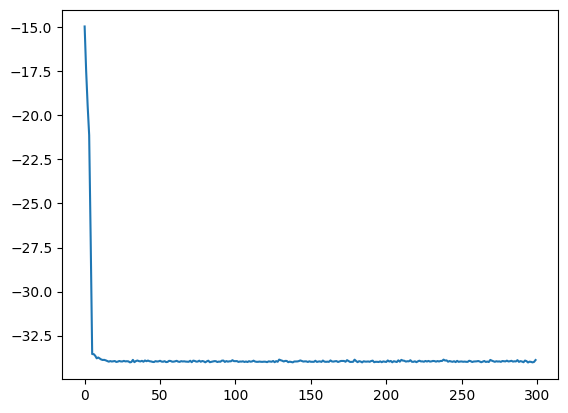

In [72]:
import matplotlib.pyplot as plt
# to plot the data, access it!
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])